In [1]:
!pip install --upgrade torch==1.12.1
!pip install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 734.1 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cpu
    Uninstalling torch-1.11.0+cpu:
      Successfully uninstalled torch-1.11.0+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cpu requires torch==1.11.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.12.1 which is incompatible.
torchaudio 0.11.0+cpu requires torch==1.11.0, but you have torch 1.12.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires torch<1.12.0,>=1.10.0, but you have torch 1.12.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 18.6 MB/s eta 0:00:0000:0100:01
     ━━

In [2]:
import os 
import cv2 
import time
import torch
import numpy as np 
import matplotlib.pyplot as plt 


from torch import nn 
from typing import Any
from torch.backends import mps
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter


bar = "="
version = torch.__version__
writer = SummaryWriter('./logs')

if mps.is_available() :
    device = torch.device('mps')
elif torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print(f'{bar*10}Device INFO{bar*10}')
print(f'PyTorch Version :{version}')
print(f'Device :{device}')
print(bar*31)

==========Device INFO==========
PyTorch Version :1.13.0+cu117
Device :cpu


In [3]:
transformer = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomGrayscale(p=0.5),
    #transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor()
])

In [4]:
lable_name = ['0', '1']
dataset = ImageFolder('/kaggle/input/bic123', transform=transformer)
dataset.classes

['0', '1']

In [5]:
ims, lables = dataset[0]
print(f'Image Shape :{ims.shape}')
print(f'Label :{lable_name[lables]}')

Image Shape :torch.Size([3, 224, 224])
Label :0


In [6]:
labs = []
images = []
debug = False
show_num = 5
show_ims_nums = 25



for i in tqdm(range(show_ims_nums)) :
    
    ims, lables = dataset[i]
    ims = ims.detach().numpy()
    ims = ims.transpose(1, 2, 0)

    lables = lable_name[lables]
    images.append(ims)
    labs.append(lables)

print(f'Processed Image :{images[0].shape}')

  0%|          | 0/25 [00:00<?, ?it/s]

Processed Image :(224, 224, 3)


  0%|          | 0/25 [00:00<?, ?it/s]

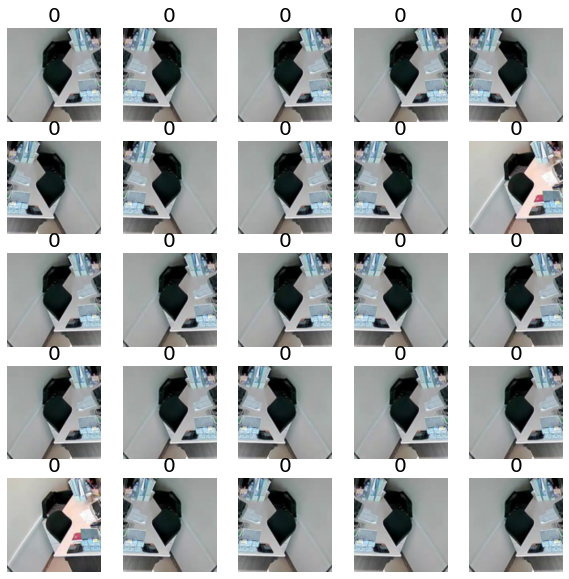

In [7]:
plt.figure(figsize=(10, 10))
for i in tqdm(range(show_ims_nums)):
    ax = plt.subplot(show_num, show_num, i + 1)

    if debug:

        #ax.set_title(labs[i], fontproperties='SimHei', fontsize=20)
        plt.imshow(images[i])
        plt.axis("on")
        
    else :
        
        ax.set_title(labs[i], fontproperties='SimHei', fontsize=20)
        plt.imshow(images[i])
        plt.axis("off")

In [8]:
batch_size = 8
num_works = 0
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_works)
# testing 
for ims, lable in loader :
    print(f'Image Shape :{ims.shape}')
    print(f'Lable :{lable.shape}')
    break

Image Shape :torch.Size([8, 3, 224, 224])
Lable :torch.Size([8])


In [13]:
model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def fit(model: nn.Module, loader: DataLoader, optimizer:torch.optim.Optimizer, loss_fn: Any, device: Any, Epochs: int, Loss_List) :
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=5)
    print(optimizer.defaults['lr'])

    for epoch in range(Epochs) :
        model.to(device)
        model.train()

        epochs_loss = 0.0
        epochs_acc = 0.0
        step = 0
       
        for image, lable in tqdm(loader, leave=False) :
            image = image.to(device)
            lable = lable.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True) :
                model_out = model(image)
                loss = loss_fn(model_out, lable)
                _, pred = torch.max(model_out, 1)

                loss.backward()
                optimizer.step()
                scheduler.step()
                
                epochs_acc += torch.sum(pred == lable.data)
                epochs_loss += loss.item() * len(model_out)

                writer.add_scalar(f'{epoch} Acc', epochs_acc, global_step=step)

            step += 1
        
        data_size = len(loader.dataset)
        epochs_loss = epochs_loss / data_size
        epochs_acc = epochs_acc.double() / data_size
        print(f'Epoch {epoch + 1}/{Epochs} | Loss: {epochs_loss:.4f} | Acc: {epochs_acc:.4f}')
        Loss_List.append(epochs_loss)
        
        writer.add_scalar('Loss', epochs_loss, global_step=epoch)
        writer.add_scalar('Acc',epochs_acc, global_step=epoch)

    torch.save(model.state_dict(),'model.bin')
    print('Model Saved!!')


In [16]:
epochs_loss_list = []

fit(model=model,
    loader=loader,
    optimizer=optimizer,
    loss_fn=loss_fn, 
    device=device,
    Epochs=3,
    Loss_List=epochs_loss_list)

0.0001


  0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 0.0196 | Acc: 0.9937


  0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.0068 | Acc: 0.9977


  0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.0071 | Acc: 0.9979
==>> Model Saved!!


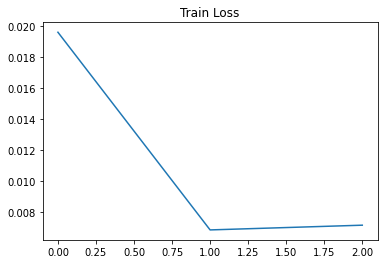

In [21]:
plt.title('Train Loss')
plt.plot(epochs_loss_list)
plt.show()